In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy.stats import *
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

data_path = '../../data/'
SCdata_path = '../../tmp/scRNAseqdata/'

In [2]:
cancer_type_colors = {
     'BrM:LUSC':'#245096',
     'BrM:BRCA':"#A55AAB",
     'BrM:HNSC':'#8a152e',
     'BrM:ESCA':'#936939',
     'BrM:URO':'#000000',
     'BrM:SCLC':'#5bc2b2',
     'BrM:LUAD':"#A3C2F4",
     'BrM:SKCM':"#3A9D58" }

colors_sampletype = {'TUMOR':'#B9B9B8','CSF':'#005C70'}
colors_samplepreservation = {'FRESH':'#5CA7ED','METHANOL':'#E09F1F','CRYOPRESERVED':'#42464A'}

SCtumorcsf = pd.read_excel(data_path+'Table S1.xlsx',sheet_name='H')
SCtumor = pd.read_excel(data_path+'Table S1.xlsx',sheet_name='G')

# scRNASeq - Analysis of tumor merged data (prior to batch normalisation)

## Cell counts across tumor samples pre- and post- cell filtering

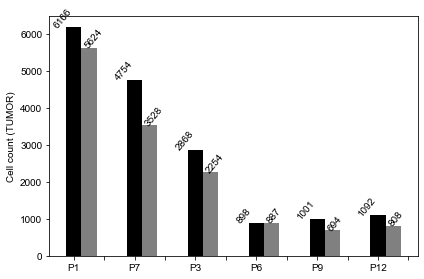

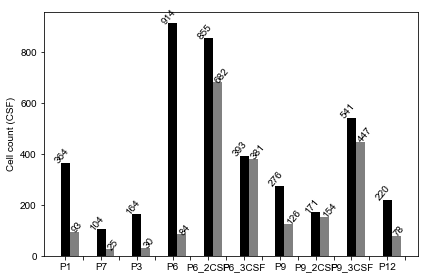

In [7]:
#File generated in scRNAseq_tumorMerged.R
for sampletype in ['TUMOR','CSF']:
    cellcounts = pd.read_csv(SCdata_path+'all'+sampletype+'merged_cellcounts.tsv',header=None,names=['SAMPLE','TYPE','COUNT'],sep='\t') 

    i = 0
    colors = ['black','grey']
    labels = []
    for row in cellcounts.to_dict(orient='records'):
        if i % 2 == 0:
            color = colors[0]
        else:
            color = colors[1]

        if i % 2 !=0 :
            plt.bar(i-0.5,row['COUNT'],width=0.5,color=color)
            plt.text(i-0.7,row['COUNT'],str(row['COUNT']),rotation=50)
            labels.append('')
        else:
            plt.bar(i,row['COUNT'],width=0.5,color=color)
            plt.text(i-0.7,row['COUNT'],str(row['COUNT']),rotation=50)
            labels.append(row['SAMPLE'])
        i+=1

    plt.xticks(range(0,i),labels)
    plt.ylabel('Cell count ('+sampletype+')')
    plt.tight_layout()
    plt.show()

## Analysis of batch effecy by sample preservation technique

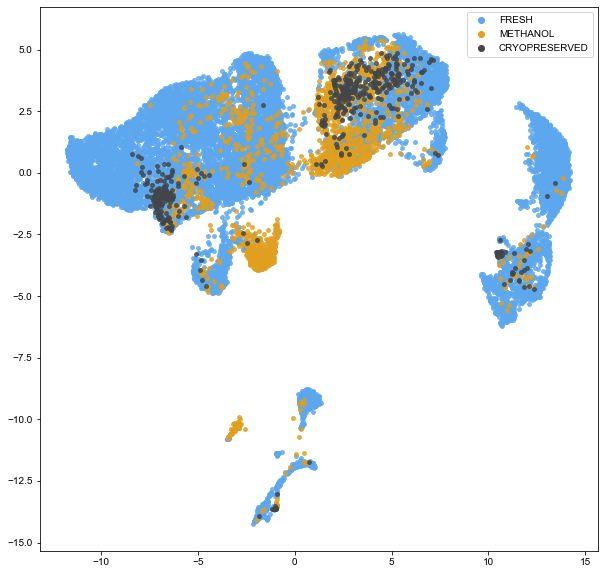

In [4]:
#File generated in scRNAseq_tumorMerged.R
umap_values = pd.read_csv(SCdata_path+'allTUMORmerged_UMAP.tsv',sep='\t',index_col=[0]).reset_index() 

cell_origin = {cell:cluster for cluster,clusterdf in SCtumor.groupby('Sample preservation') for cell in clusterdf['Cell ID'].tolist() }

fig,ax = plt.subplots(figsize=(10, 10))
for row in umap_values.to_dict(orient='records'):
    if row['index'] in cell_origin:
        plt.scatter(float(row['UMAP_1']),float(row['UMAP_2']),
                    color=colors_samplepreservation[cell_origin[row['index']]],s=15,alpha=0.8)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors_samplepreservation.values()]
plt.legend(markers, colors_samplepreservation.keys(), numpoints=1)
plt.show()    

In [13]:
def gen_heatmap_entropy(cluster_annotations):
    total_cells = {}
    total_cells_c = {}
    total_cells_p = {}
    for col in cluster_annotations.columns:
        if col != 'cluster':
            total_cells[col] = cluster_annotations[col].sum()
        total_cells_c[col] = []
        total_cells_p[col] = []    

    for cluster,clusterdf in cluster_annotations.groupby('cluster'):
        for col in cluster_annotations.columns:
            if col != 'cluster':
                total_cells_c[col].append(clusterdf[col].values[0])
                total_cells_p[col].append(clusterdf[col].values[0]/float(total_cells[col]))
        total_cells_c['cluster'].append(cluster)
        total_cells_p['cluster'].append(cluster)

    total_cellsdf = pd.DataFrame(total_cells_c)
    ptotal_cellsdf = pd.DataFrame(total_cells_p)
    fig,ax = plt.subplots(figsize=(2, 5)) 
    g = sns.heatmap(ptotal_cellsdf.set_index('cluster'),cmap='Blues',annot=total_cellsdf.set_index('cluster'), fmt='g',vmin=0,vmax=1)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 10)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
    plt.show()

    entropy_persample = entropy(ptotal_cellsdf[[c for c in cluster_annotations.columns if c !='cluster']].values)
    entropyDF = pd.DataFrame(entropy_persample).T.rename(columns={i:c for i,c in enumerate([c for c in cluster_annotations.columns if c !='cluster'])})
    fig,ax = plt.subplots(figsize=(3,1))
    sns.heatmap(entropyDF,vmin=0,vmax=2,annot=True)
    plt.show()

    entropy_percluster = entropy(ptotal_cellsdf[[c for c in cluster_annotations.columns if c !='cluster']].T.values)
    entropyDF = pd.DataFrame(entropy_percluster)
    fig,ax = plt.subplots(figsize=(1,5))
    sns.heatmap(entropyDF,vmin=0,vmax=2,annot=True)
    plt.show()
    
    return entropyDF


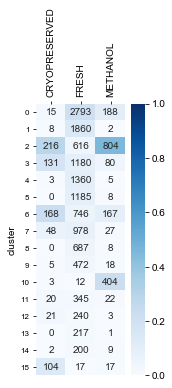

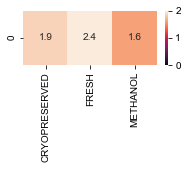

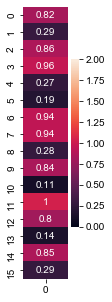

In [42]:
#File generated in scRNAseq_tumorMerged.R
cluster_annotations1 = pd.read_csv(SCdata_path+'allTUMORmerged_SAMPLETECHdist2.tsv',sep='\t',index_col=False).rename(columns={'Unnamed: 3':'cluster'})
entropyDF1 = gen_heatmap_entropy(cluster_annotations1)

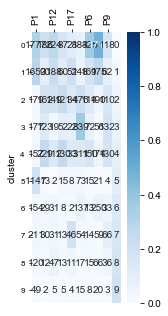

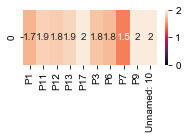

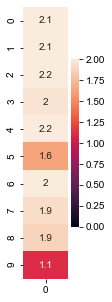

In [43]:
#File generated in scRNAseq_tumorIntegrated.R
cluster_annotations2 = pd.read_csv(SCdata_path+'allTUMORintegrated_SAMPLETECHdist.tsv',sep='\t',index_col=False).rename(columns={'Unnamed: 9':'cluster'})
entropyDF2 = gen_heatmap_entropy(cluster_annotations2)

MannwhitneyuResult(statistic=0.0, pvalue=1.3946622502117465e-05)
FC= 3.164546150983634


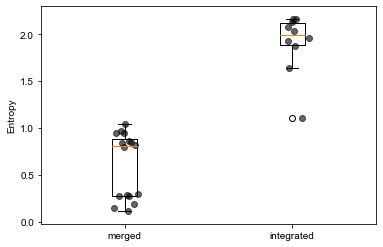

In [44]:
data = [entropyDF1[0].tolist(),entropyDF2[0].tolist()]
plt.boxplot(data)
plt.ylabel('Entropy')
for i in [1,2]:
    y = data[i-1]
    x = np.random.normal(i, 0.04, size=len(y))
    plt.scatter(x, y, alpha=0.6, color='black')
plt.xticks([1,2],['merged','integrated'])
print(mannwhitneyu(data[0],data[1]))
print('FC=',np.mean(data[1])/float(np.mean(data[0])))
plt.savefig('entropybox.svg')
plt.show()


# scRNAseq - QC analysis: detected genes

In [9]:
SCtumorcsf = pd.read_excel(data_path+'Table S1.xlsx',sheet_name='G')
SCtumor = pd.read_excel(data_path+'Table S1.xlsx',sheet_name='H')

In [10]:
def QCexpressed_genes(metadata,sampletype):
    sample_med = {sample:np.median(sampledf.nFeature_RNA) for sample, sampledf in metadata.groupby('Patient ID')}
    sorted_samples = [s[0] for s in sorted(sample_med.items(), key=operator.itemgetter(1))]
    data = [metadata[metadata['Patient ID']==sample].nFeature_RNA.tolist() for sample in sorted_samples]
    xlabels = [sample for sample in sorted_samples]

    for i in range(1,len(xlabels)+1):
        y = data[i-1]
        x = np.random.normal(i, 0.04, size=len(y))
        plt.scatter(x, y, alpha=0.6,color=colors_sampletype[sampletype])


    violin_parts = plt.violinplot(data,showmeans = True)
    for part in ('cbars','cmins','cmaxes','cmeans'):
        violin_parts[part].set_facecolor('black')
        violin_parts[part].set_edgecolor('black')

    for pc in violin_parts['bodies']:
        pc.set_facecolor(colors_sampletype[sampletype])
        pc.set_edgecolor(colors_sampletype[sampletype])

    plt.xticks(range(1,len(xlabels)+1),xlabels,rotation=90)
    plt.ylabel('Number of expressed genes')
    plt.title(sampletype)
    plt.show()

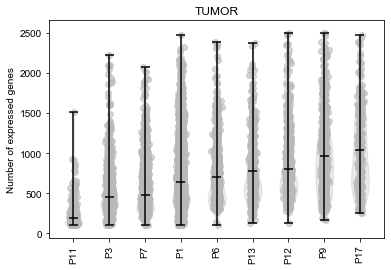

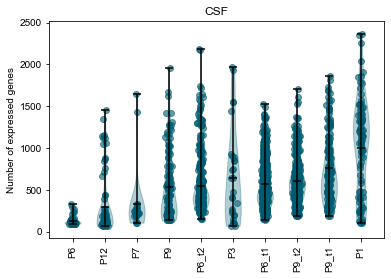

In [11]:
QCexpressed_genes(SCtumor,'TUMOR')
QCexpressed_genes(SCtumorcsf[SCtumorcsf['Sample type']=='CSF'],'CSF')

In [12]:
print('all tumors cells',len(SCtumor))
print('all csf cells',len(SCtumorcsf[SCtumorcsf['Sample type']=='CSF']), 'all matched tumor+csf cells',len(SCtumorcsf))

all tumors cells 15415
all csf cells 2100 all matched tumor+csf cells 15895


Median expressed genes tumor 490.0 Median expressed genes CSF 478.0


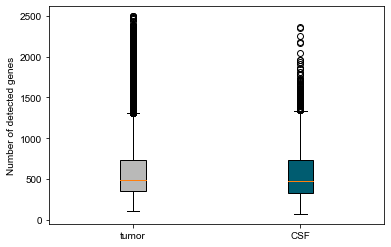

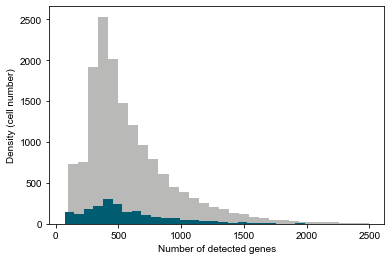

In [13]:
data = [SCtumor.nFeature_RNA.tolist()]
data.append(SCtumorcsf[SCtumorcsf['Sample type']=='CSF'].nFeature_RNA.tolist())
bplot = plt.boxplot(data, patch_artist=True)
for patch, color in zip(bplot['boxes'], ['#B9B9B8','#005C70']):
        patch.set_facecolor(color)
plt.xticks([1,2],['tumor','CSF'])
plt.ylabel('Number of detected genes')
print('Median expressed genes tumor',np.median(data[0]),'Median expressed genes CSF',np.median(data[1]))
plt.show()

plt.hist(data[0],color='#B9B9B8',bins=30)
plt.hist(data[1],color='#005C70',bins=30)
plt.ylabel('Density (cell number)')
plt.xlabel('Number of detected genes')
plt.show()